## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns

from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "iphone"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

![](../images/trends_iphone.png)

In [3]:
raw_df = pd.read_csv("../data/iphone_trends.csv", parse_dates=["week"])

raw_df.tail()

,week,iphone_11,iphone_12,iphone_13,iphone_14,iphone_15
256,2023-10-22,10,10,14,16,23
257,2023-10-29,10,9,13,15,22
258,2023-11-05,11,10,15,17,22
259,2023-11-12,11,10,16,17,24
260,2023-11-19,12,11,17,17,24


In [4]:
releases_df = pd.DataFrame(
    data=[
        {"model": "iphone_11", "release_date": "September 20, 2019"},
        {"model": "iphone_12", "release_date": "October 23, 2020"},
        {"model": "iphone_13", "release_date": "September 24, 2021"},
        {"model": "iphone_14", "release_date": "September 16, 2022"},
        {"model": "iphone_15", "release_date": "September 22, 2023"},
    ]
)

release_dates_df = releases_df.assign(
    release_week=lambda x: (
        pd.to_datetime(x["release_date"]).dt.to_period("W-SAT").dt.start_time
        - pd.DateOffset(days=7)
    )
)

release_dates_df

,model,release_date,release_week
0,iphone_11,"September 20, 2019",2019-09-08
1,iphone_12,"October 23, 2020",2020-10-11
2,iphone_13,"September 24, 2021",2021-09-12
3,iphone_14,"September 16, 2022",2022-09-04
4,iphone_15,"September 22, 2023",2023-09-10


In [5]:
data_df = (
    raw_df.copy()
    .melt(id_vars=["week"], var_name="model", value_name="search")
    .merge(right=release_dates_df, on="model")
    .drop(columns=["release_date"])
    .assign(
        age=lambda x: (x["week"].max() - x["week"]).dt.days / 7,
        model_age=lambda x: (x["week"] - x["release_week"]).dt.days / 7,
        is_release=lambda x: (x["model_age"] == 0).astype(float),
        month=lambda x: x["week"].dt.month,
    )
)

data_df.head()

,week,model,search,release_week,age,model_age,is_release,month
0,2018-11-25,iphone_11,0,2019-09-08,260.0,-41.0,0.0,11
1,2018-12-02,iphone_11,0,2019-09-08,259.0,-40.0,0.0,12
2,2018-12-09,iphone_11,0,2019-09-08,258.0,-39.0,0.0,12
3,2018-12-16,iphone_11,0,2019-09-08,257.0,-38.0,0.0,12
4,2018-12-23,iphone_11,0,2019-09-08,256.0,-37.0,0.0,12


## EDA

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

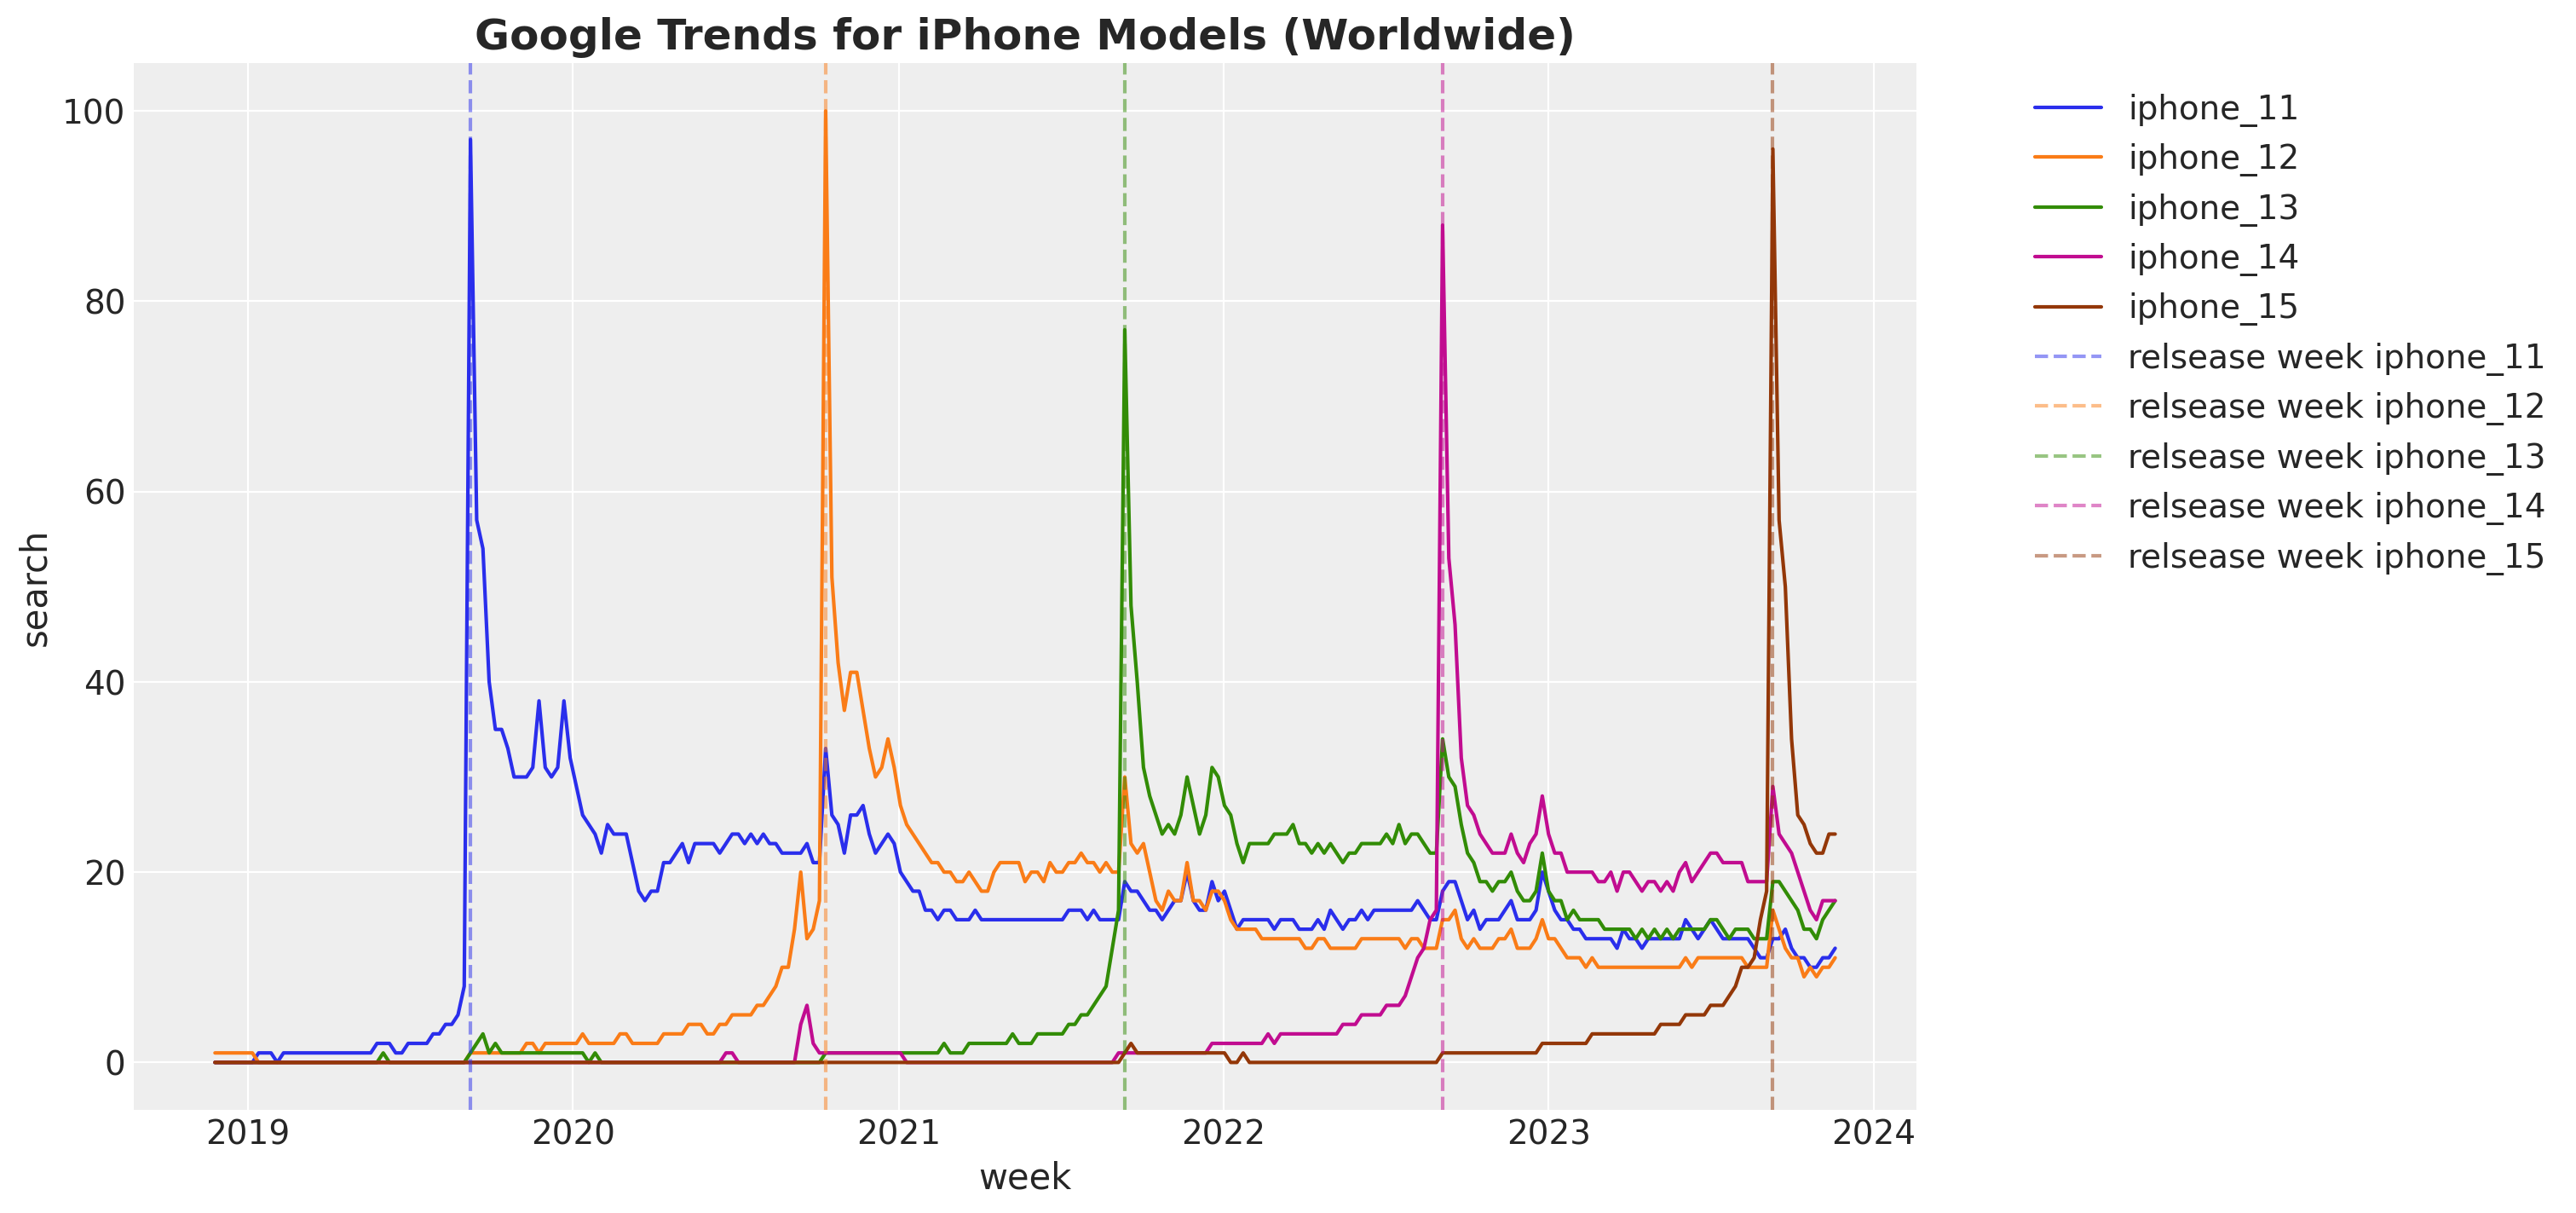

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=data_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, model in enumerate(release_dates_df["model"]):
    release_week = release_dates_df.query(f"model == '{model}'")["release_week"].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"relsease week {model}",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

<Axes: xlabel='week', ylabel='model'>

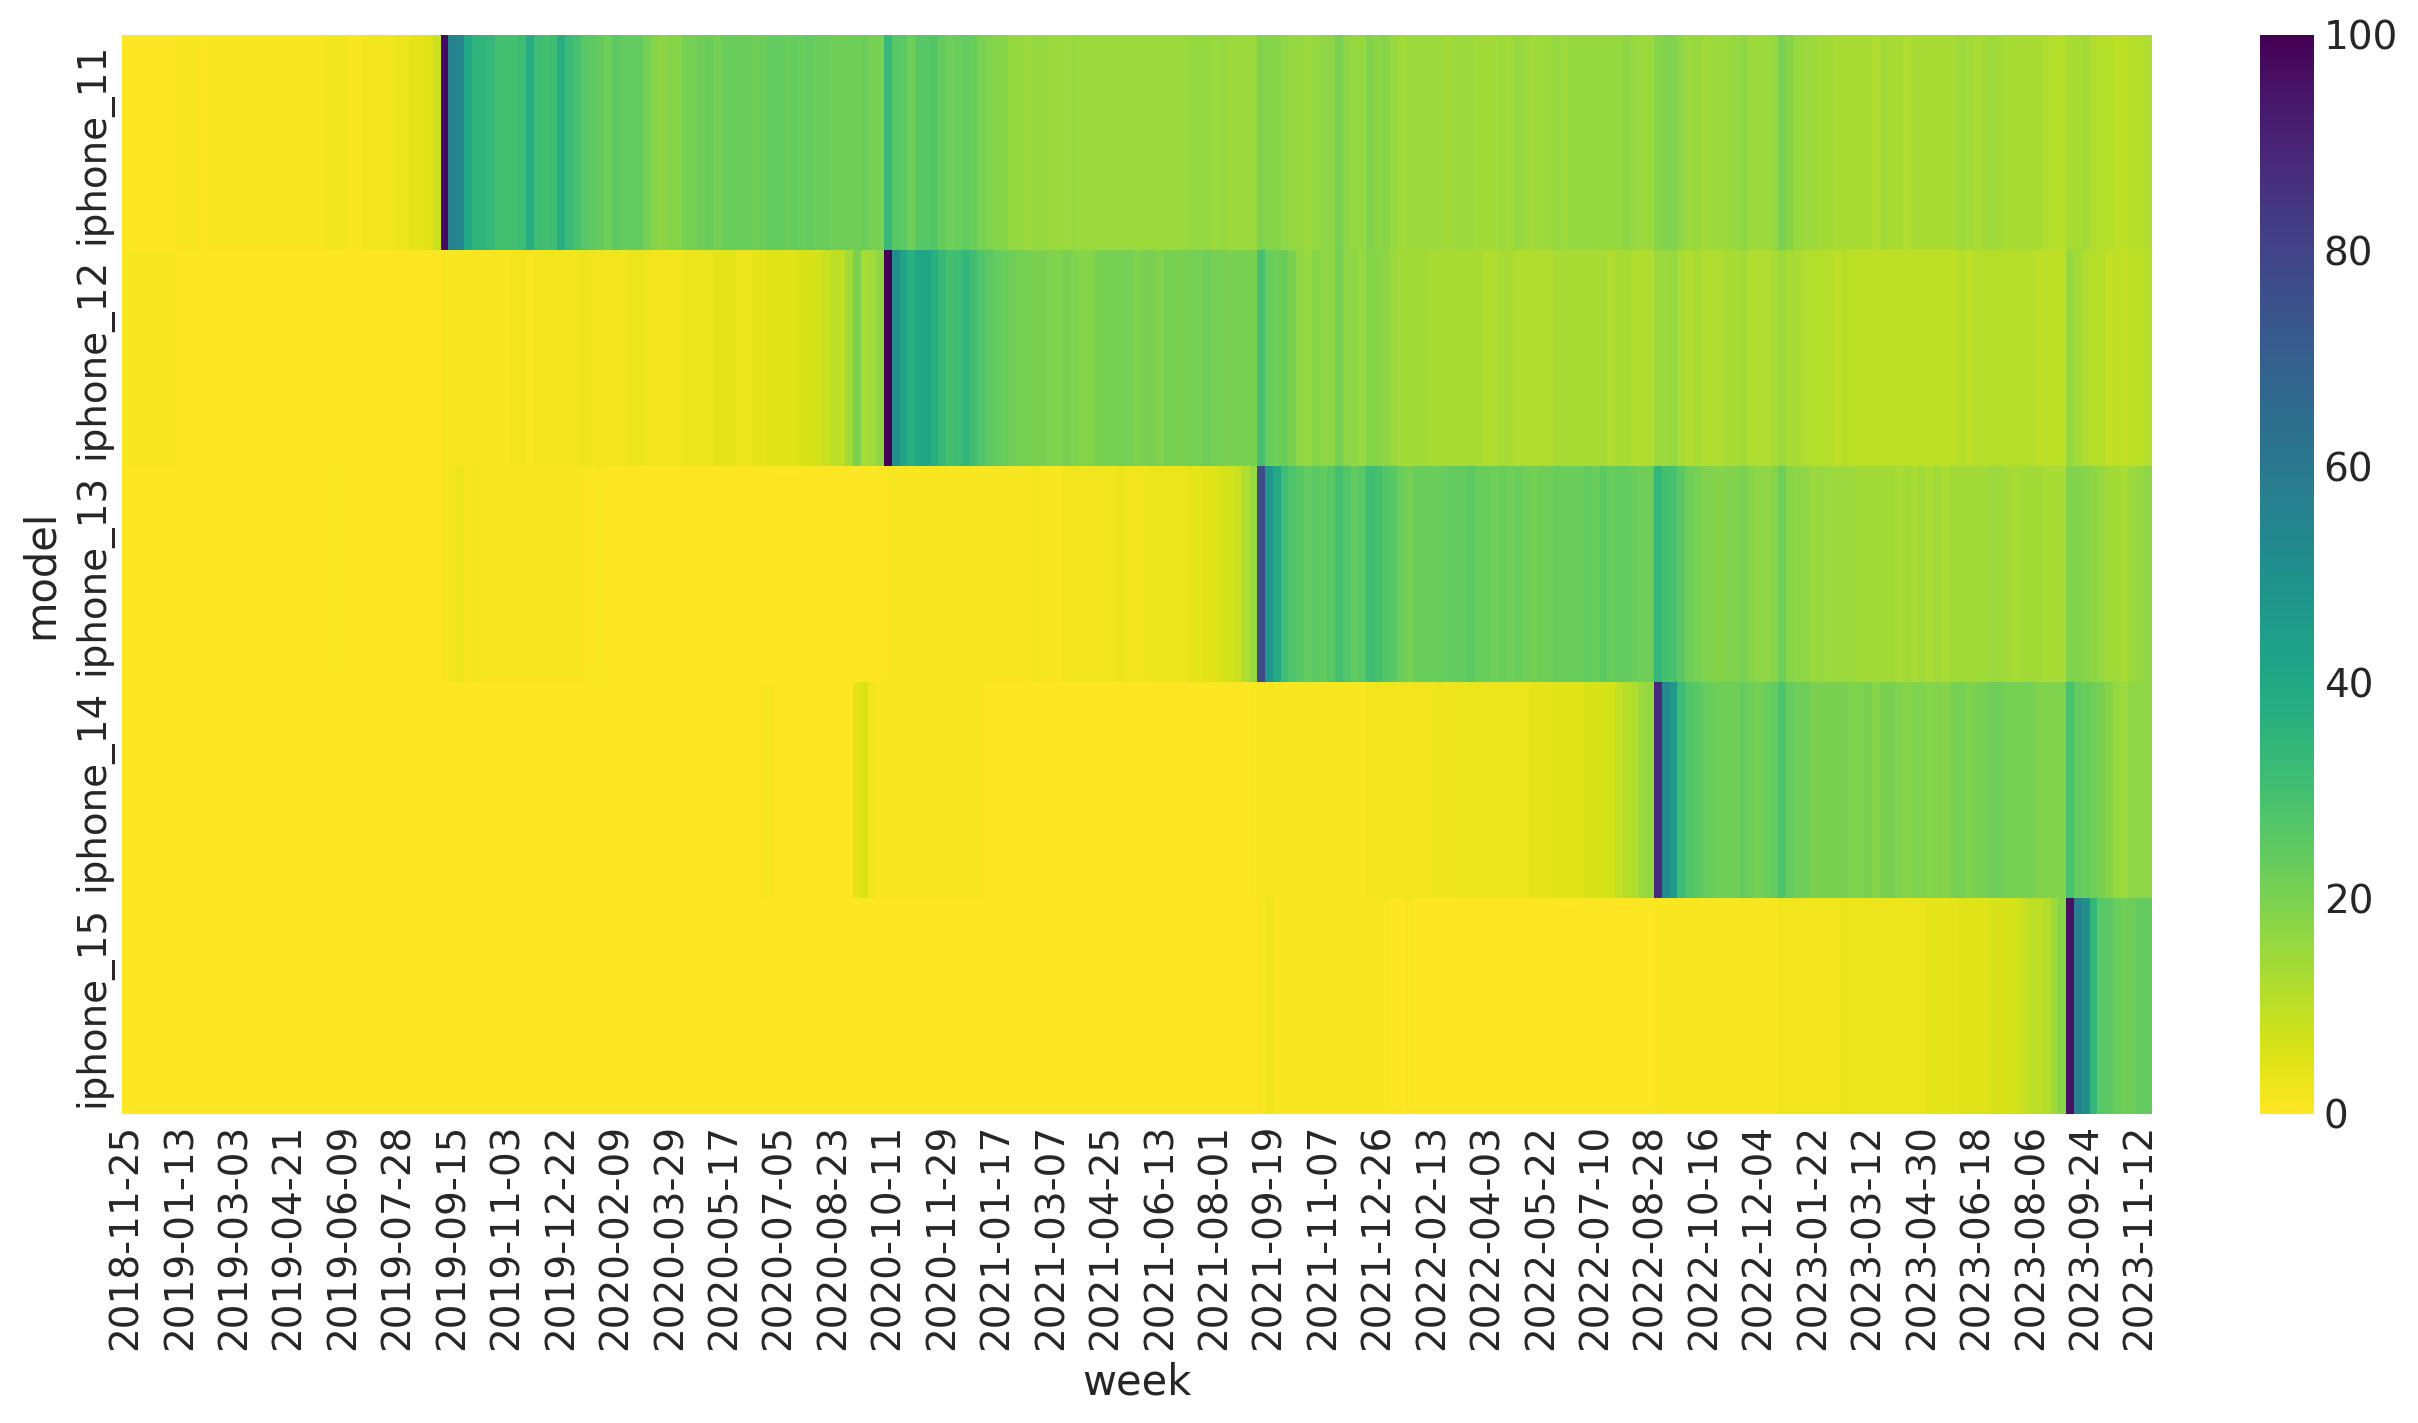

In [7]:
fig, ax = plt.subplots()
(
    data_df.assign(week=lambda x: x["week"].dt.date)[["model", "week", "search"]]
    .pivot(index="model", columns="week", values="search")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        ax=ax,
    )
)

In [8]:
test_model = "iphone_15"

train_df = data_df.query(f"model != '{test_model}'")
test_df = data_df.query(f"model == '{test_model}'")

In [9]:
train_obs = train_df.index.to_numpy()
train_iphone_model_idx, train_iphone_model = train_df["model"].factorize(sort=True)
train_month_idx, train_month = train_df["month"].factorize(sort=True)
train_age = train_df["age"].to_numpy()
train_train_model_age = train_df["model_age"].to_numpy()
train_is_release = train_df["is_release"].to_numpy()
x_train = train_df[["age", "model_age", "month"]]
train_search = train_df["search"].to_numpy()

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc_bart/bart.py:136: UserWarning: Options linear and mix are experimental and still not well tested
Use with caution.
  warnings.warn(


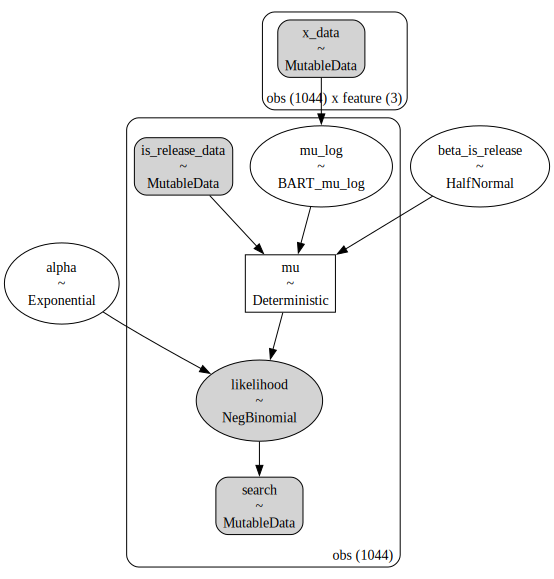

In [10]:
coords = {
    "iphone_model": train_iphone_model,
    "month": train_month,
    "feature": x_train.columns,
    "obs": train_obs,
}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    # month_idx_data = pm.MutableData(
    #     name="month_idx_data", value=train_month_idx, dims="month"
    # )
    # age_data = pm.MutableData(name="age_data", value=train_age, dims="obs")
    # model_age_data = pm.MutableData(
    #     name="model_age_data", value=train_train_model_age, dims="obs"
    # )
    is_release_data = pm.MutableData(
        name="is_release_data", value=train_is_release, dims="obs"
    )
    x_data = pm.MutableData(name="x_data", value=x_train, dims=("obs", "feature"))
    search_data = pm.MutableData(name="search", value=train_search, dims="obs")

    beta_is_release = pm.HalfNormal(name="beta_is_release", sigma=10)

    alpha = pm.Exponential(name="alpha", lam=1 / 5)

    bart_mu_log = pmb.BART(
        name="mu_log",
        X=x_data,
        Y=np.log(train_search + 0.1),
        m=100,
        response="mix",
        split_rules=[ContinuousSplitRule(), ContinuousSplitRule(), SubsetSplitRule()],
        dims="obs",
    )
    mu = pm.Deterministic(
        name="mu",
        var=pt.exp(bart_mu_log) + beta_is_release * is_release_data,
        dims="obs",
    )

    _ = pm.NegativeBinomial(
        name="likelihood",
        mu=mu,
        alpha=alpha,
        observed=search_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [11]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

Sampling: [alpha, beta_is_release, likelihood, mu_log]


Text(0.5, 1.0, 'Prior Predictive')

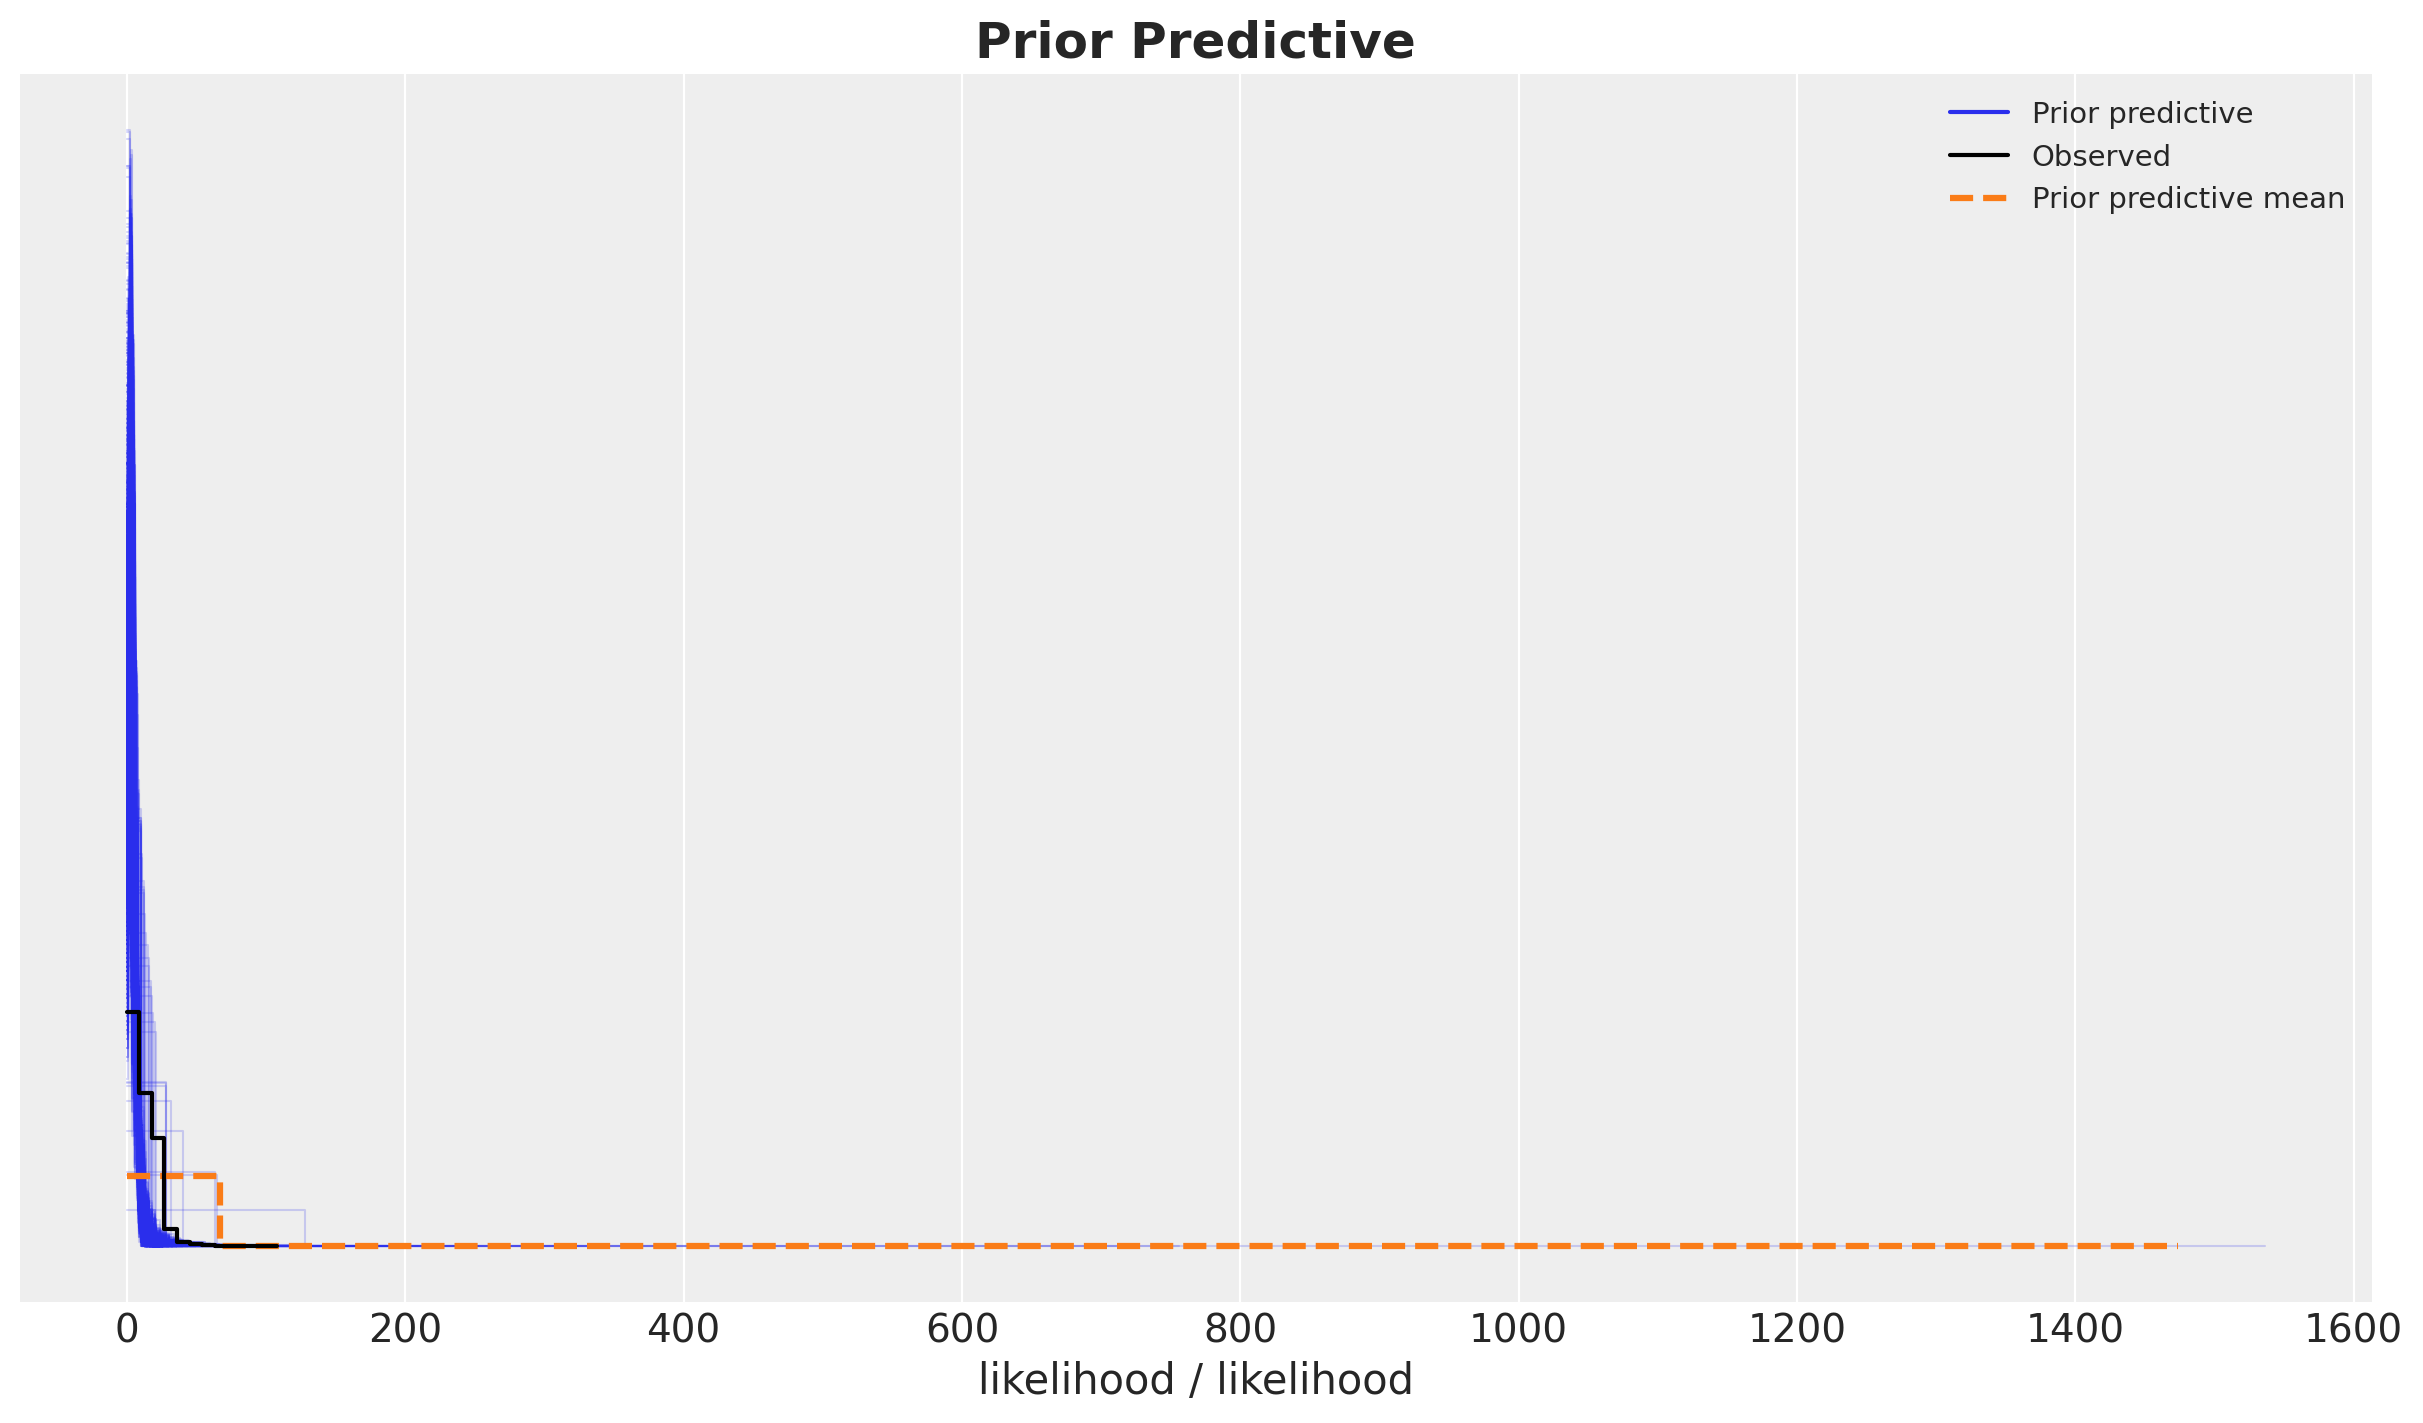

In [12]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")

In [13]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=1_000,
        chains=2,
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [beta_is_release, alpha]
>PGBART: [mu_log]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 226 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [likelihood]


<Axes: xlabel='likelihood / likelihood'>

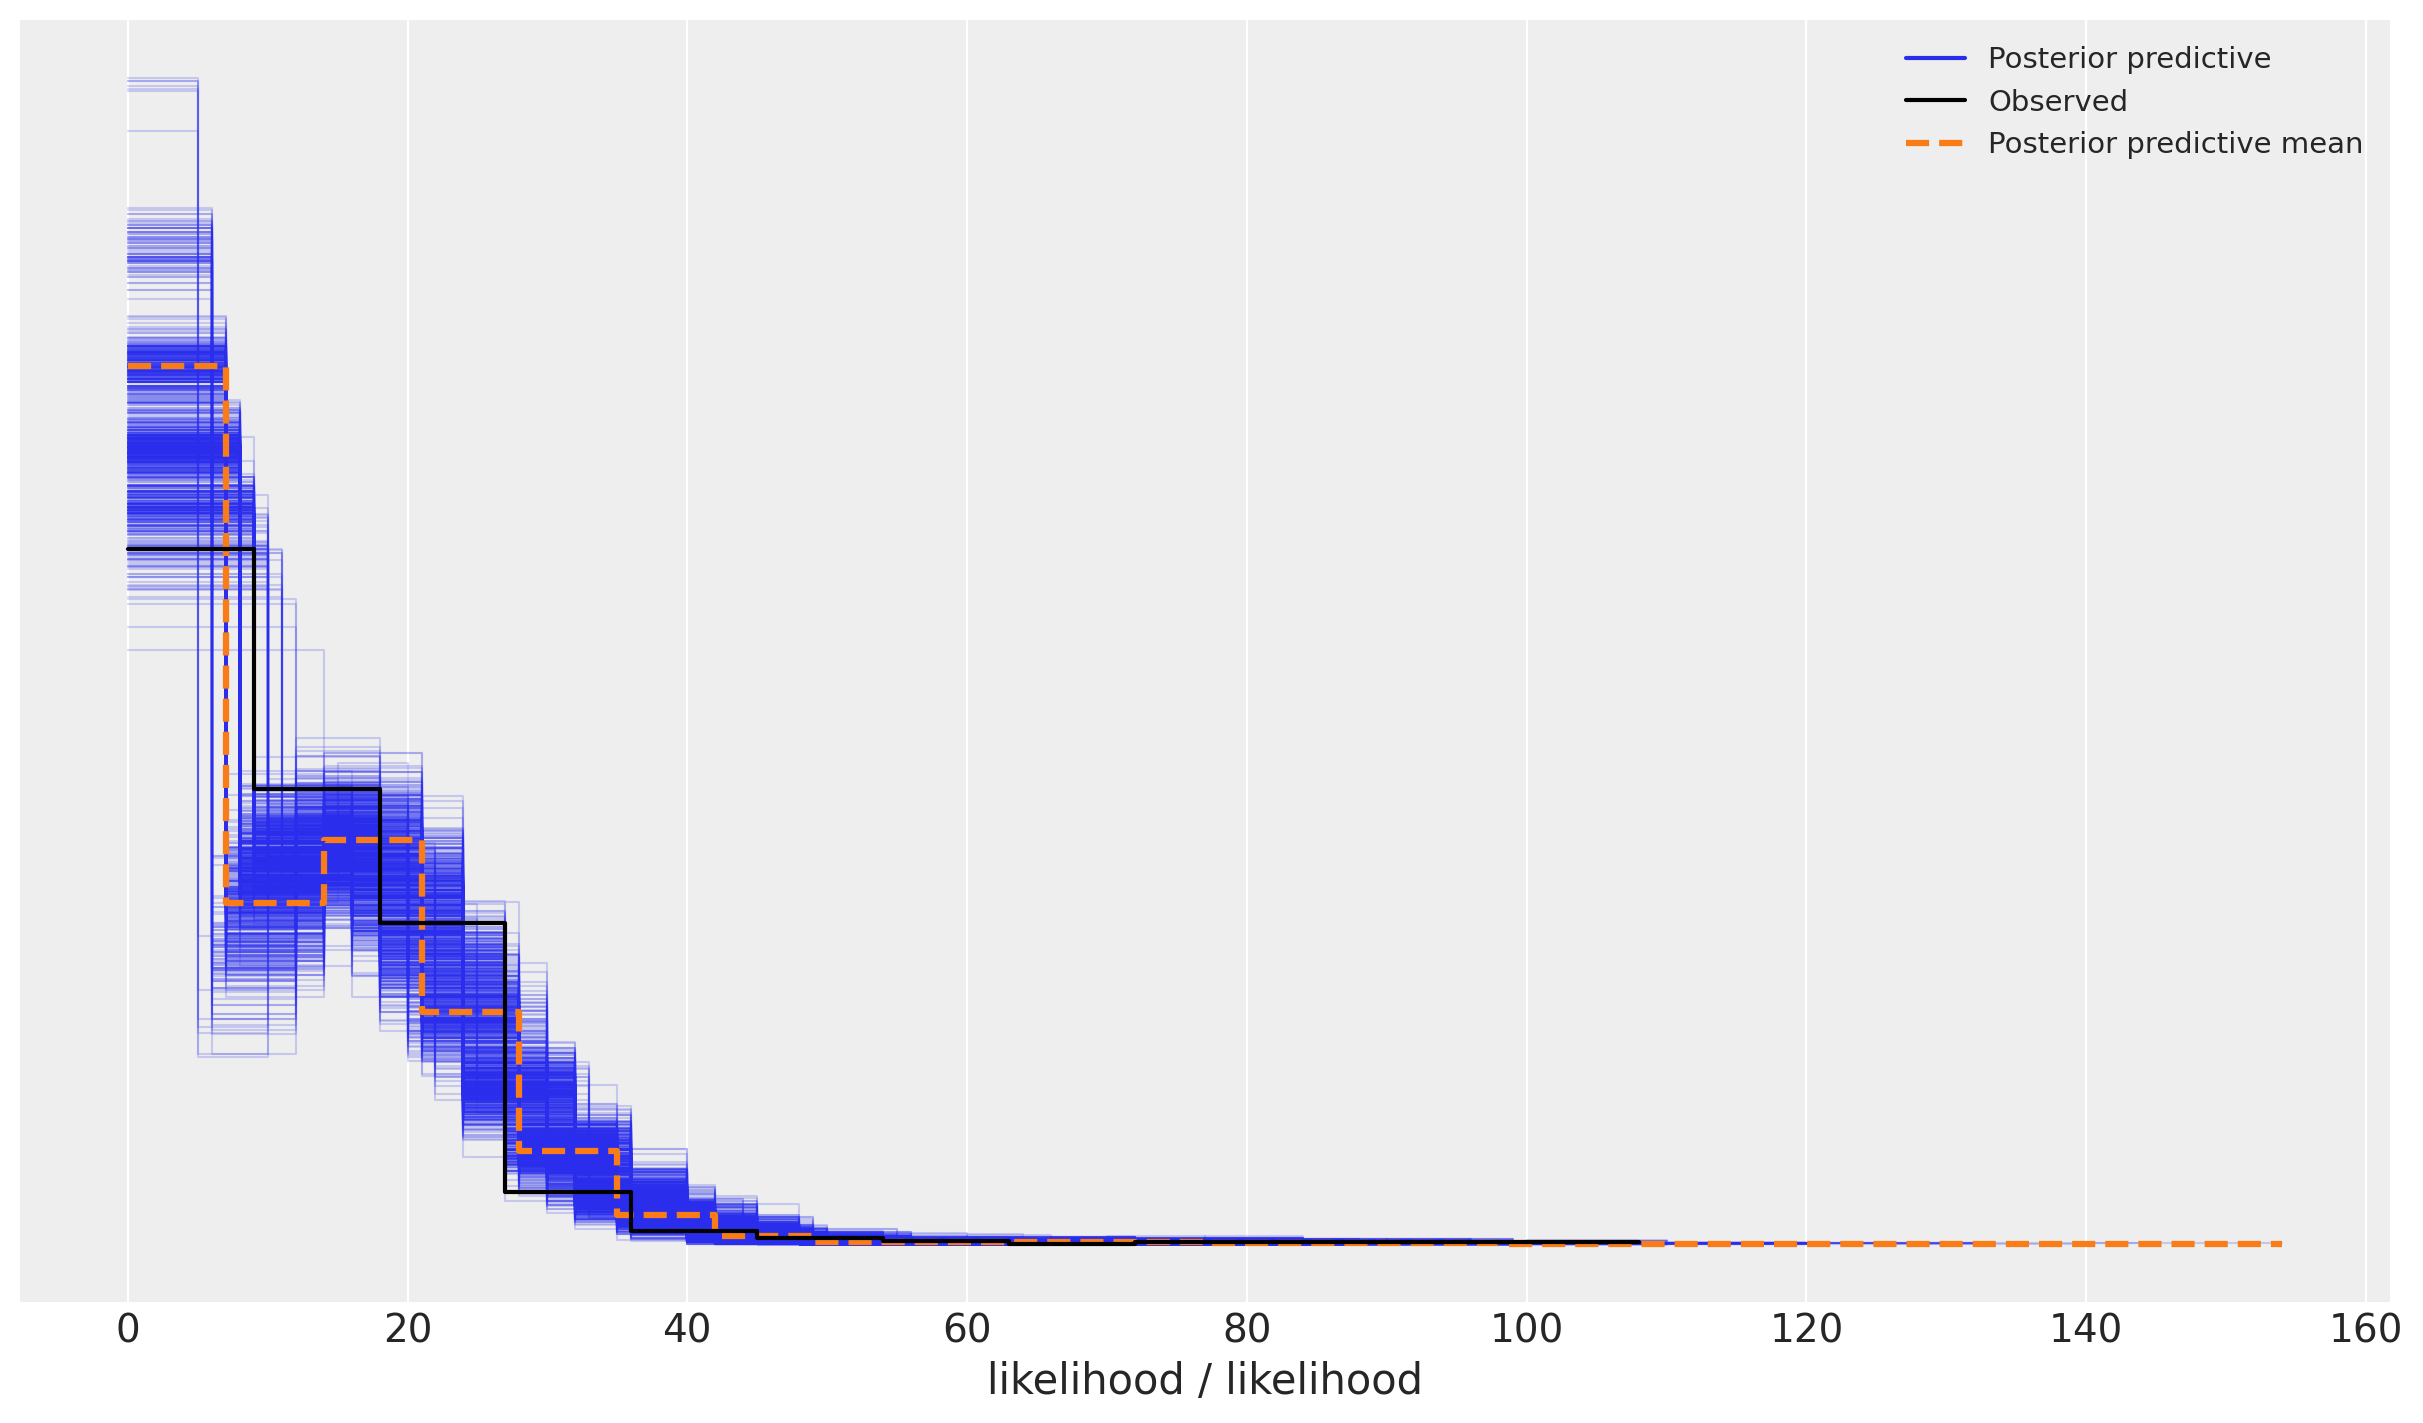

In [14]:
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
)

<Axes: xlabel='model_age', ylabel='search'>

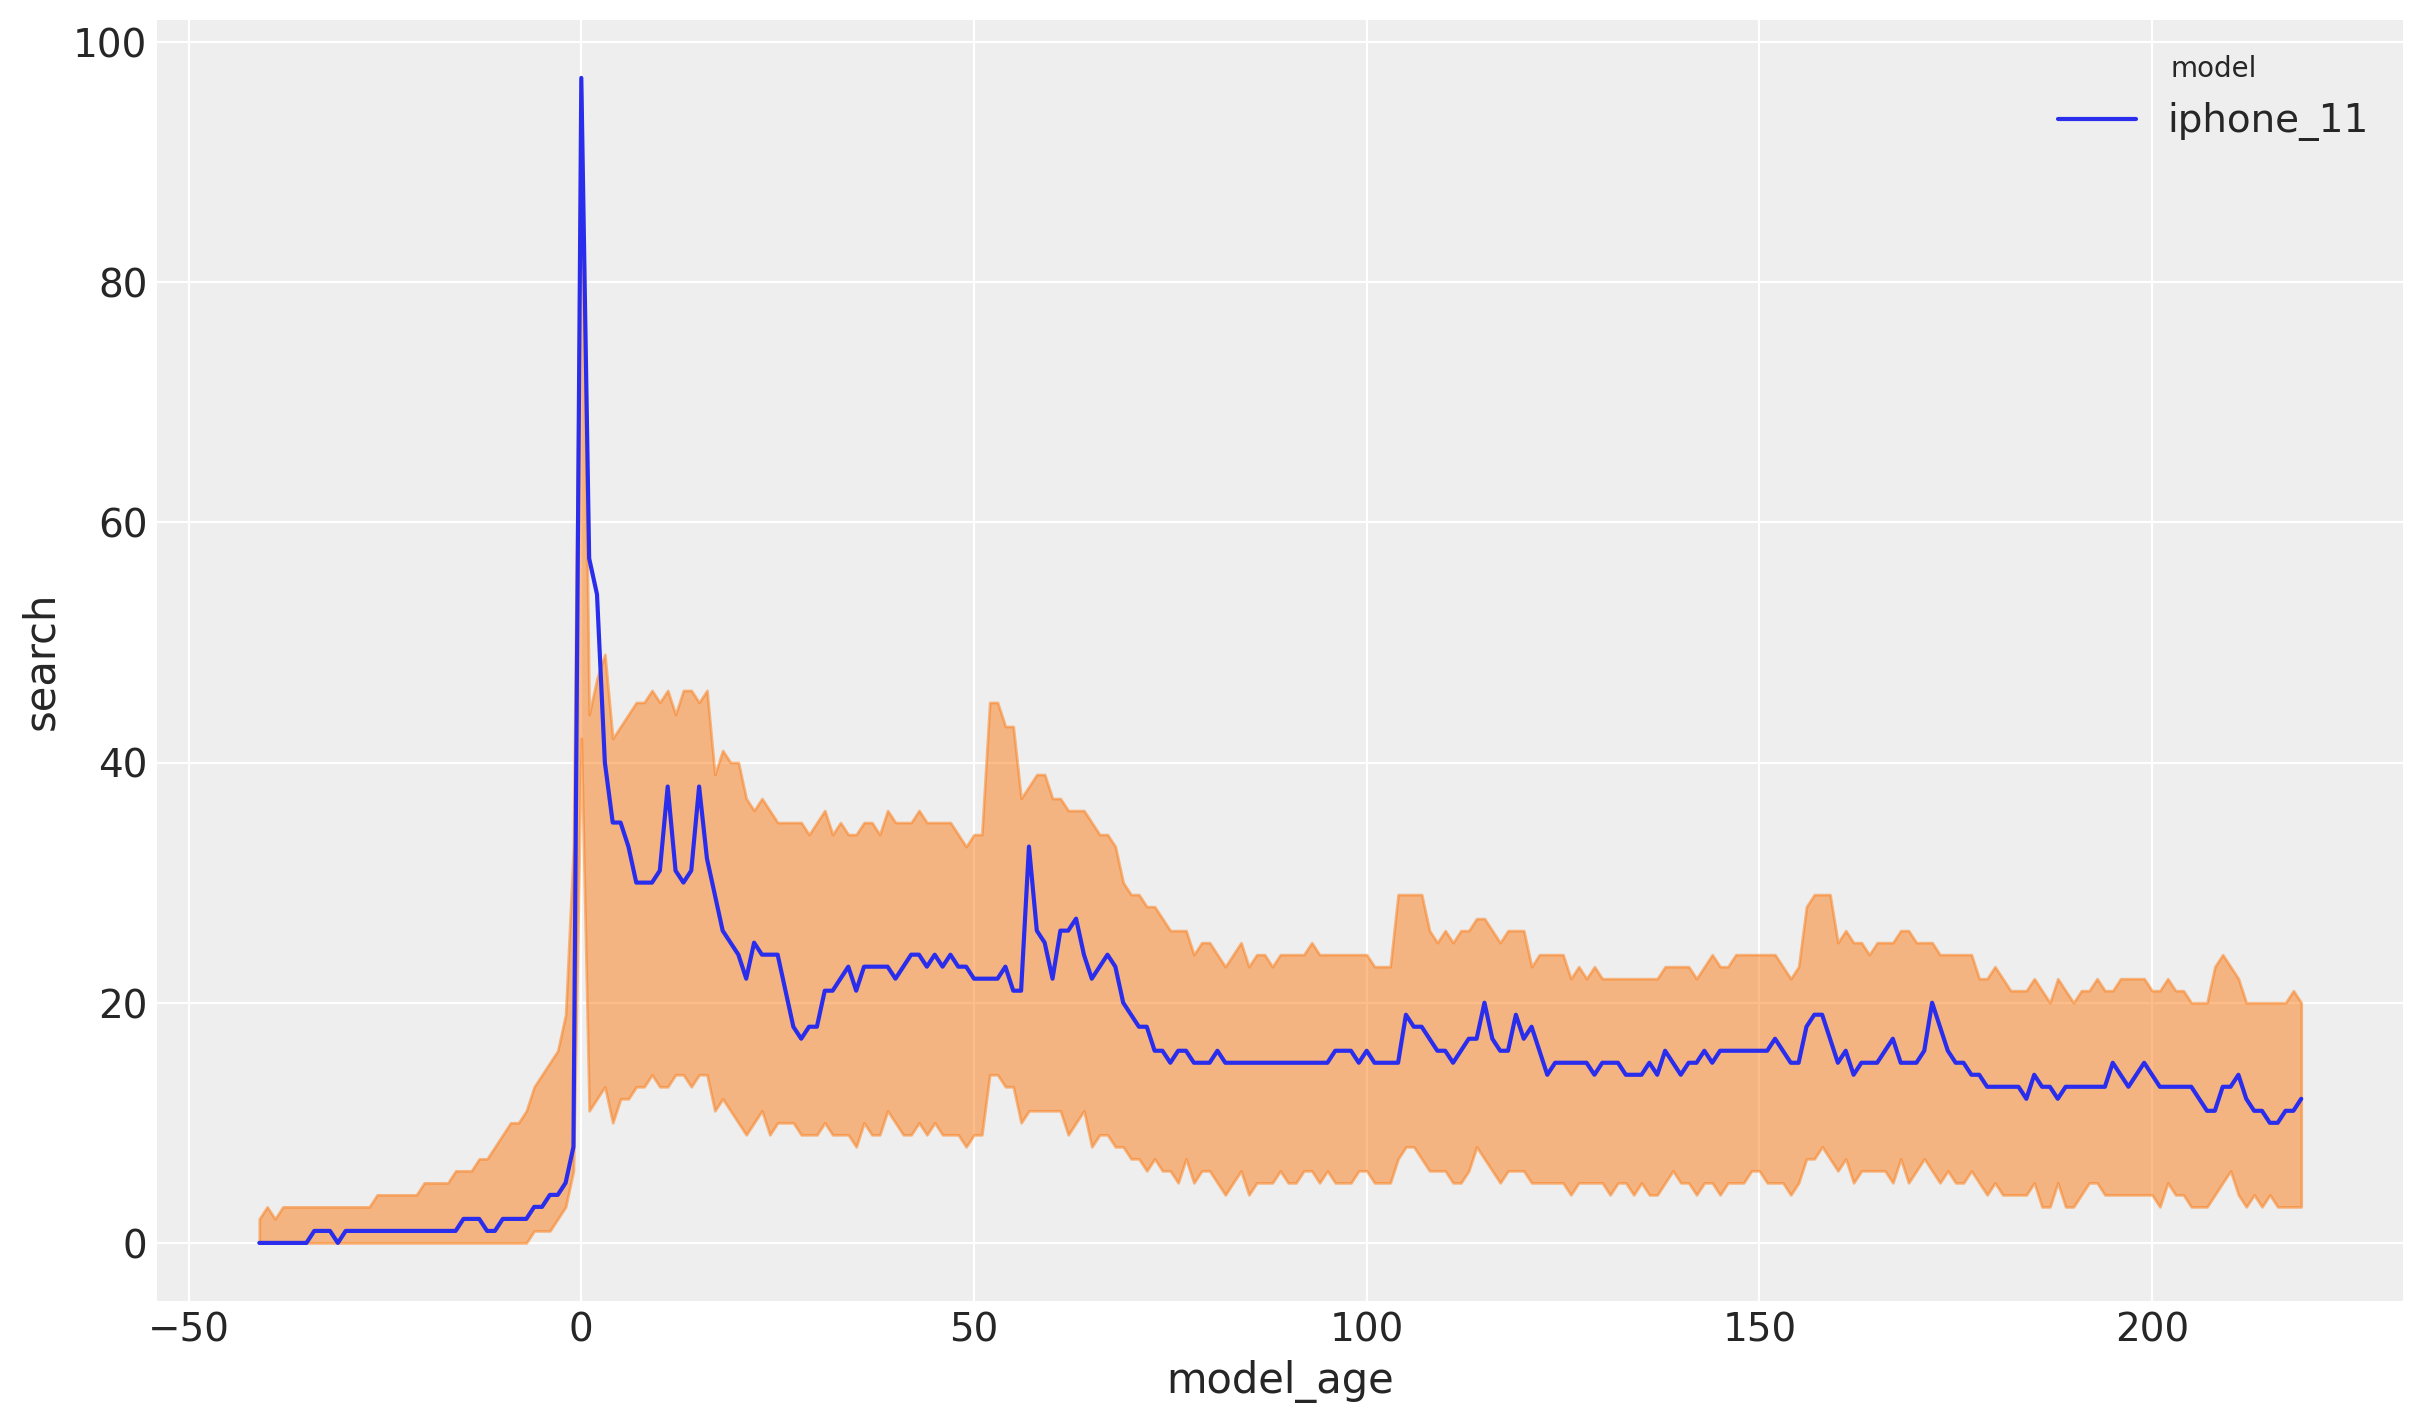

In [21]:
fig, ax = plt.subplots()
sns.lineplot(
    data=train_df[train_df["model"] == "iphone_11"],
    x="model_age",
    y="search",
    hue="model",
    ax=ax,
)

az.plot_hdi(
    x=train_df[train_df["model"] == "iphone_11"]["model_age"],
    y=posterior_predictive["posterior_predictive"]["likelihood"][
        :, :, (train_df["model"] == "iphone_11").to_numpy()
    ],
    hdi_prob=0.95,
    smooth=False,
    ax=ax,
)

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

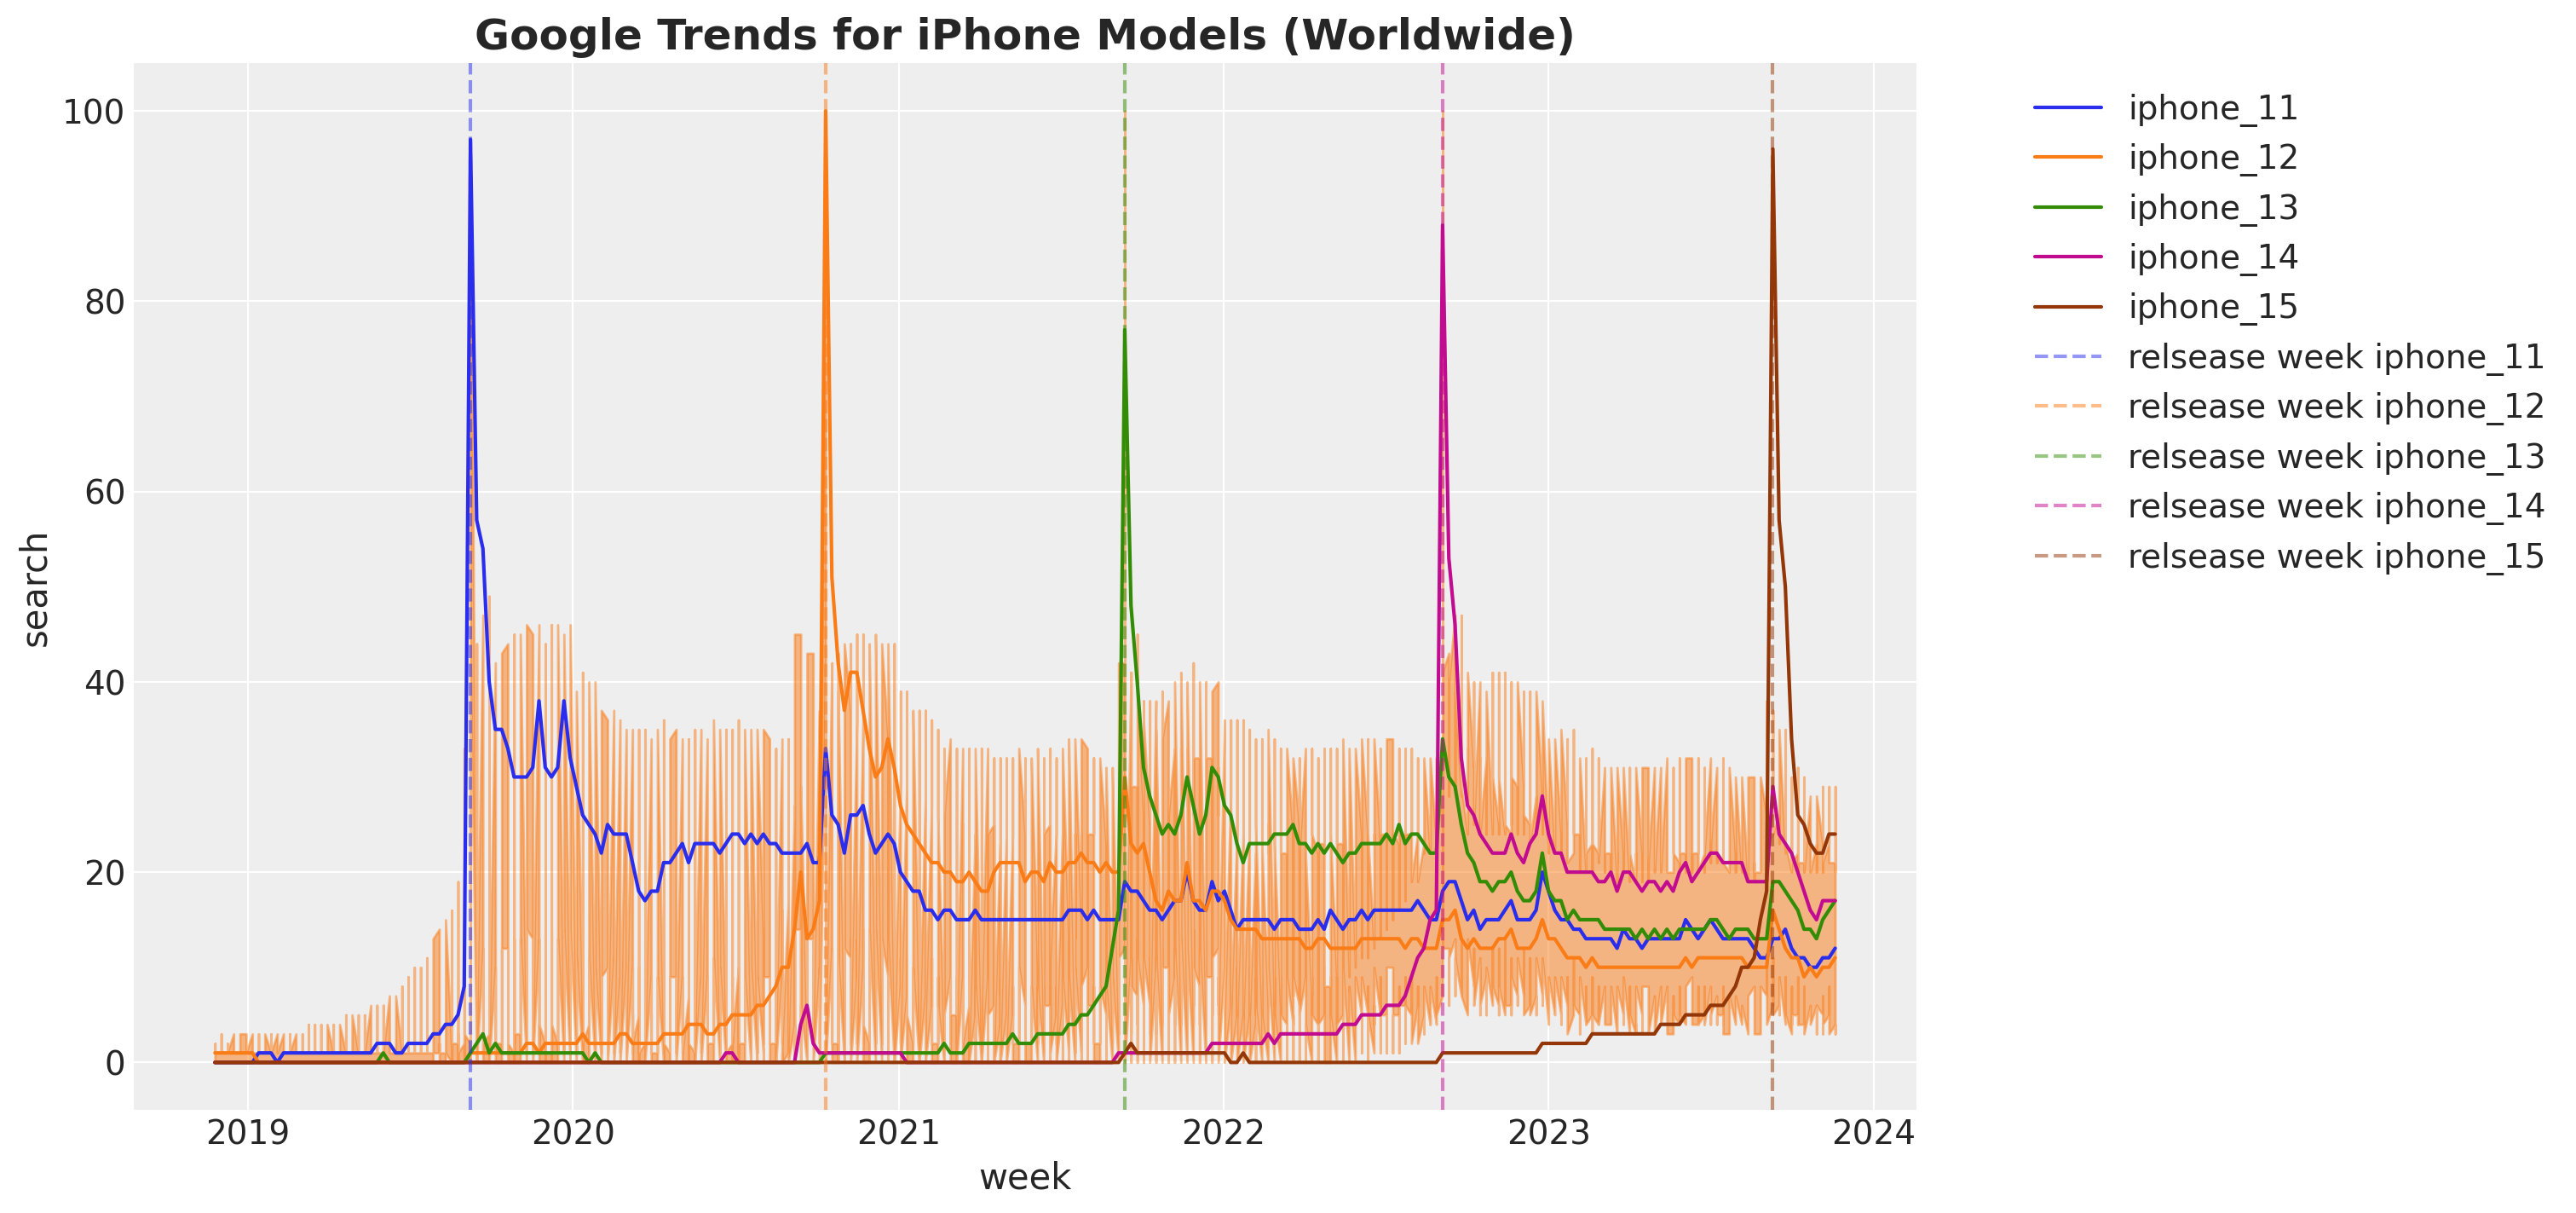

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=data_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, model in enumerate(release_dates_df["model"]):
    release_week = release_dates_df.query(f"model == '{model}'")["release_week"].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"relsease week {model}",
    )

az.plot_hdi(
    x=train_df["week"],
    y=posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.95,
    smooth=False,
    ax=ax,
)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

Text(0.5, 1.02, 'Partial Dependency Plots (PDP)')

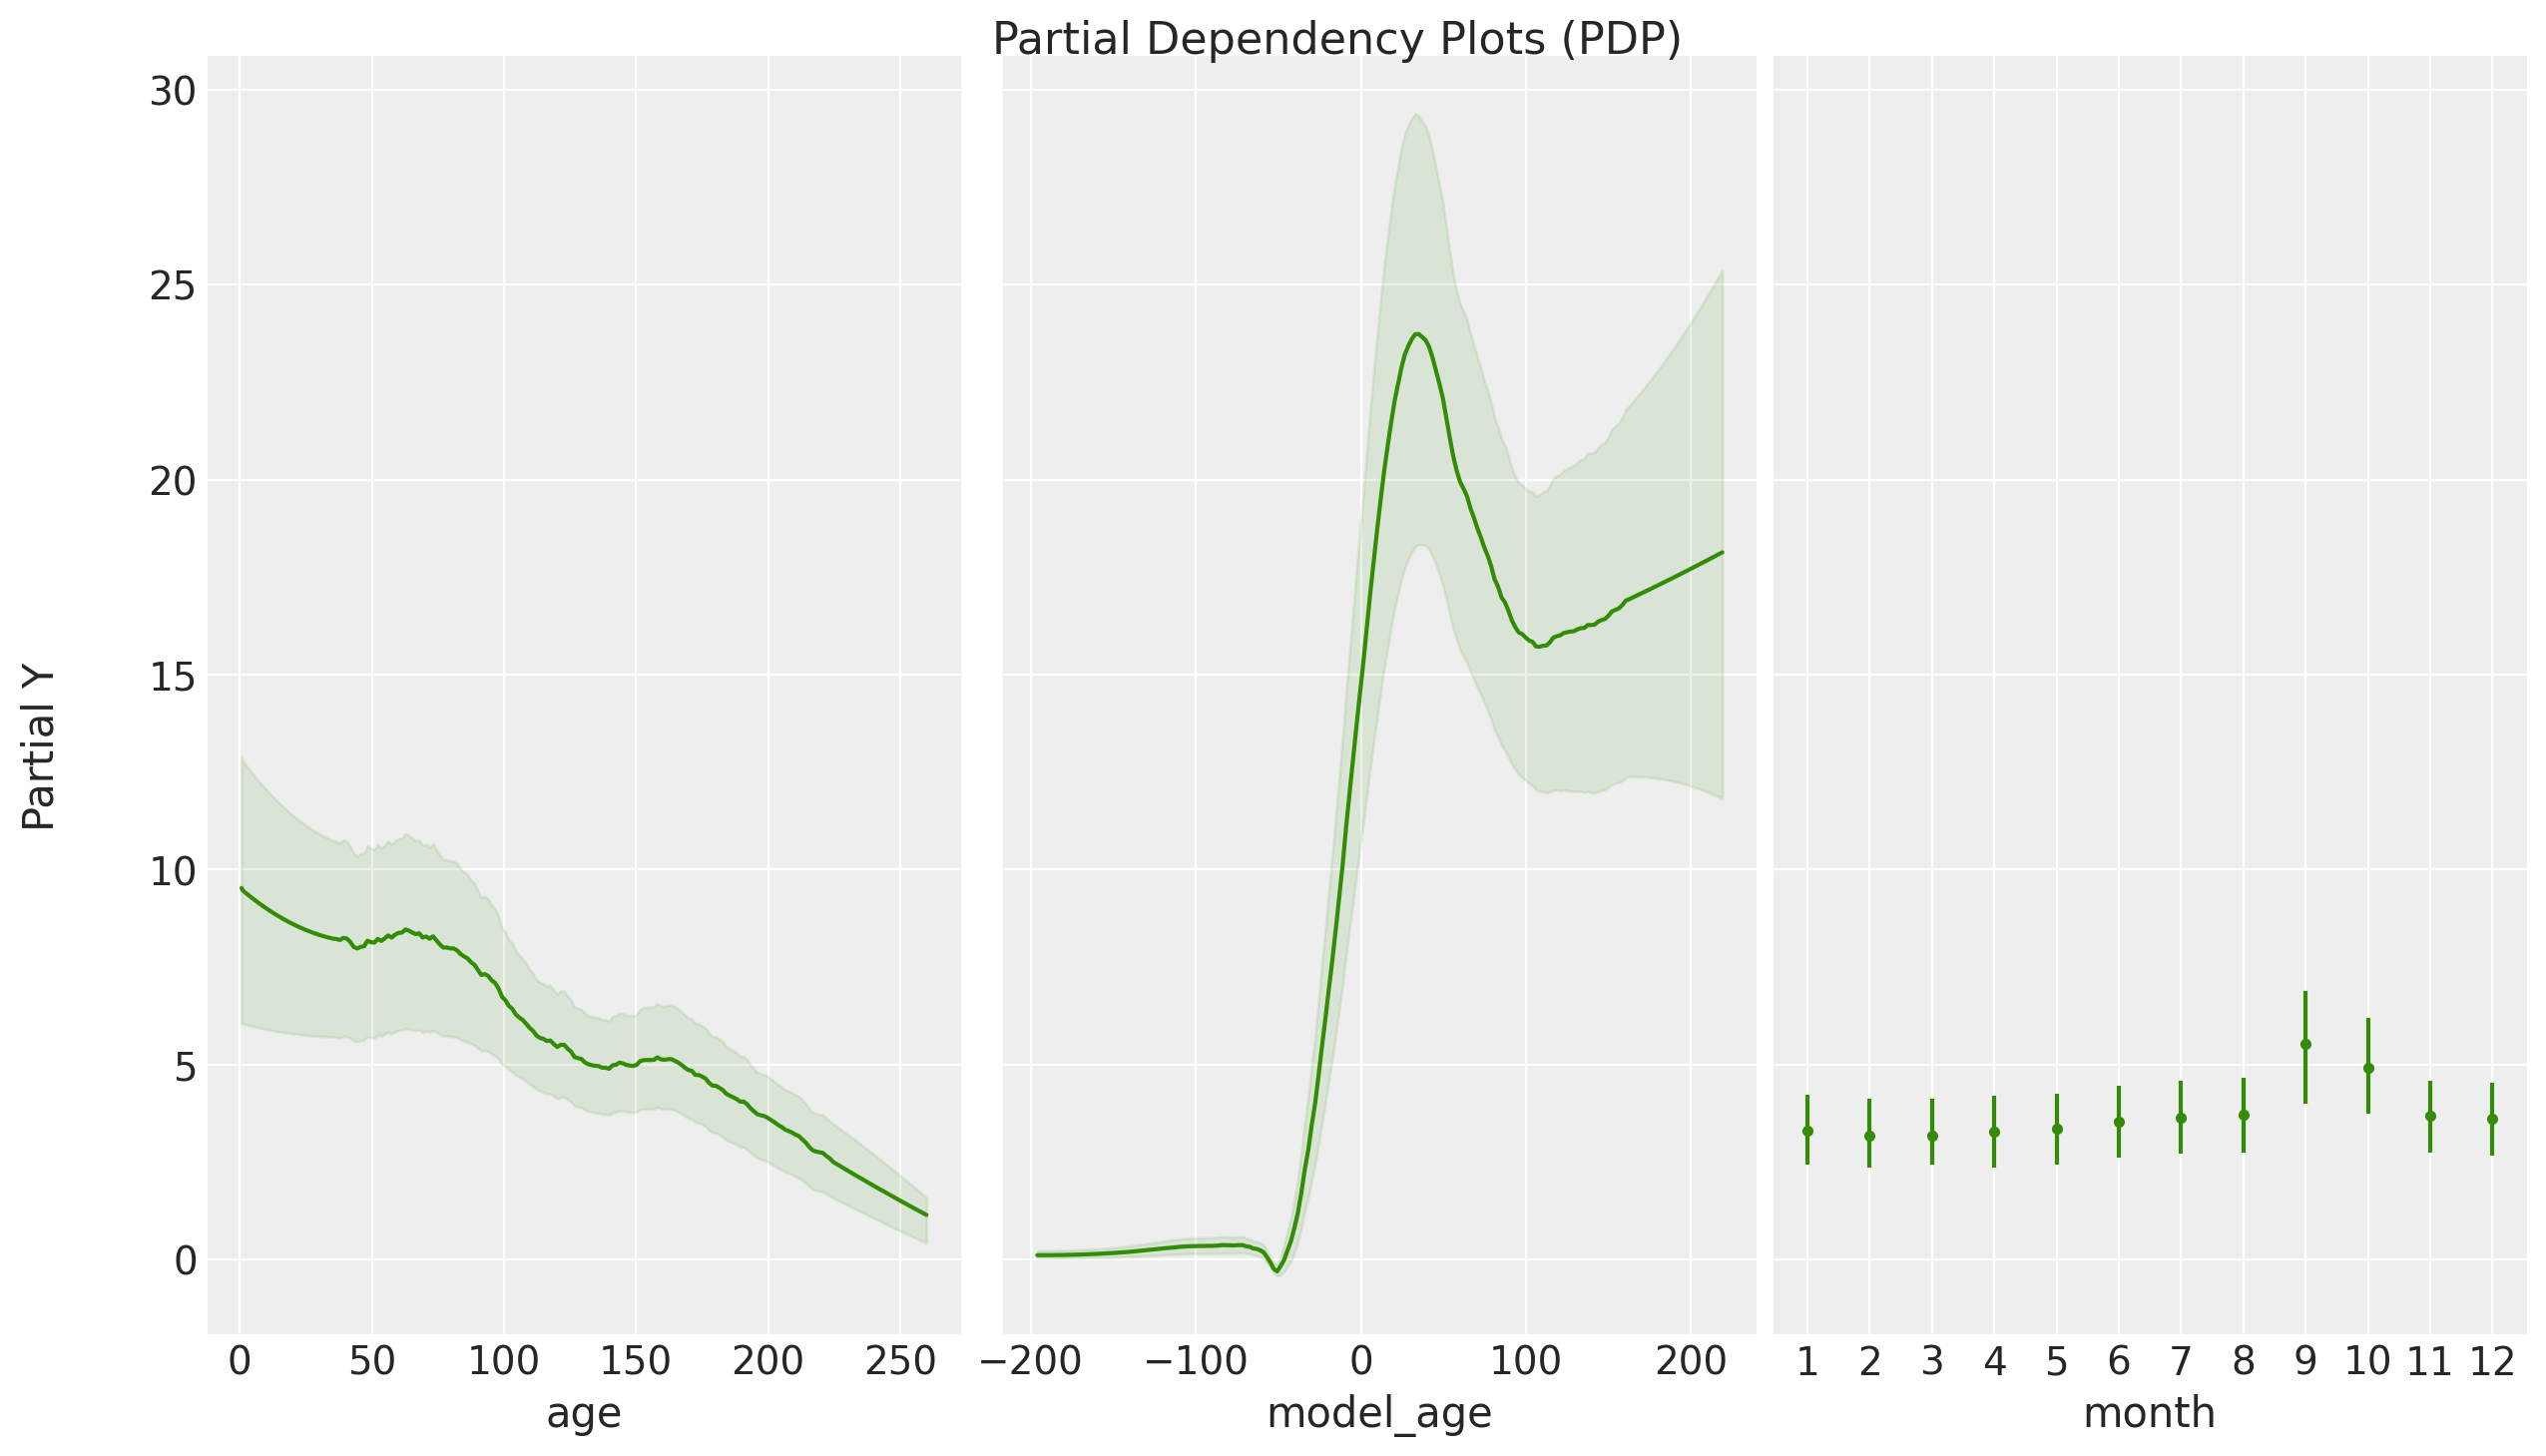

In [18]:
axes = pmb.plot_pdp(
    bartrv=bart_mu_log,
    X=x_train,
    # Y=train_search,
    func=np.exp,
    xs_interval="insample",
    samples=1_000,
    grid="wide",
    color="C2",
    color_mean="C2",
    var_discrete=[2],
    figsize=(12, 7),
    random_seed=seed,
)
# axes[0].set(ylim=(0, 0.2))
plt.gcf().suptitle(
    "Partial Dependency Plots (PDP)",
    fontsize=16,
    y=1.02,
)

In [ ]:
test_obs = test_df.index.to_numpy()
test_iphone_model_idx, test_iphone_model = test_df["model"].factorize(sort=True)
test_month_idx, test_month = test_df["month"].factorize(sort=True)
test_age = test_df["age"].to_numpy()
test_test_model_age = test_df["model_age"].to_numpy()
x_test = test_df[["age", "model_age", "month"]]
test_search = test_df["search"].to_numpy()